In [12]:
import os
from pathlib import Path
from utils import data_loader_utils
from utils import user_defined_functions as udf
import itertools 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import math
from scipy import ndimage
from scipy.stats import pearsonr
import scipy.signal as signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

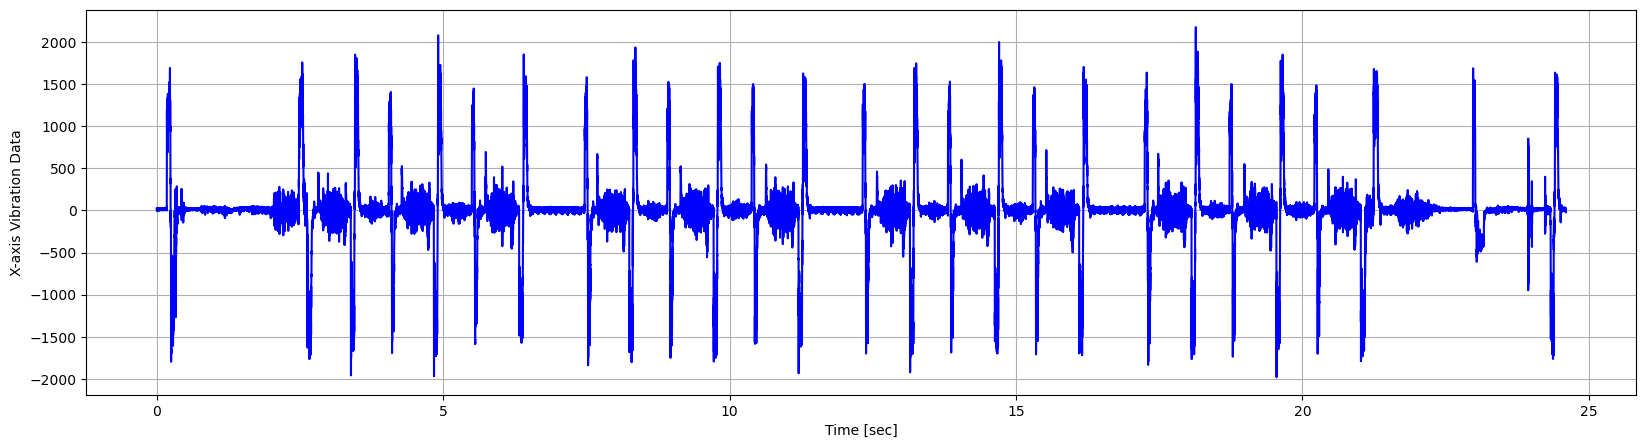

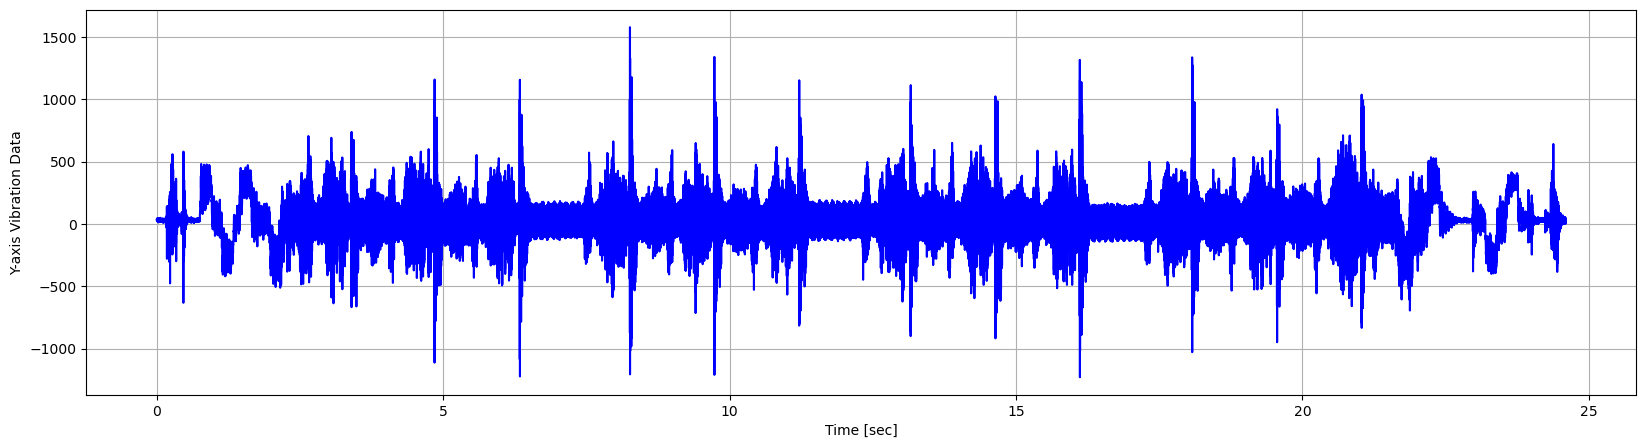

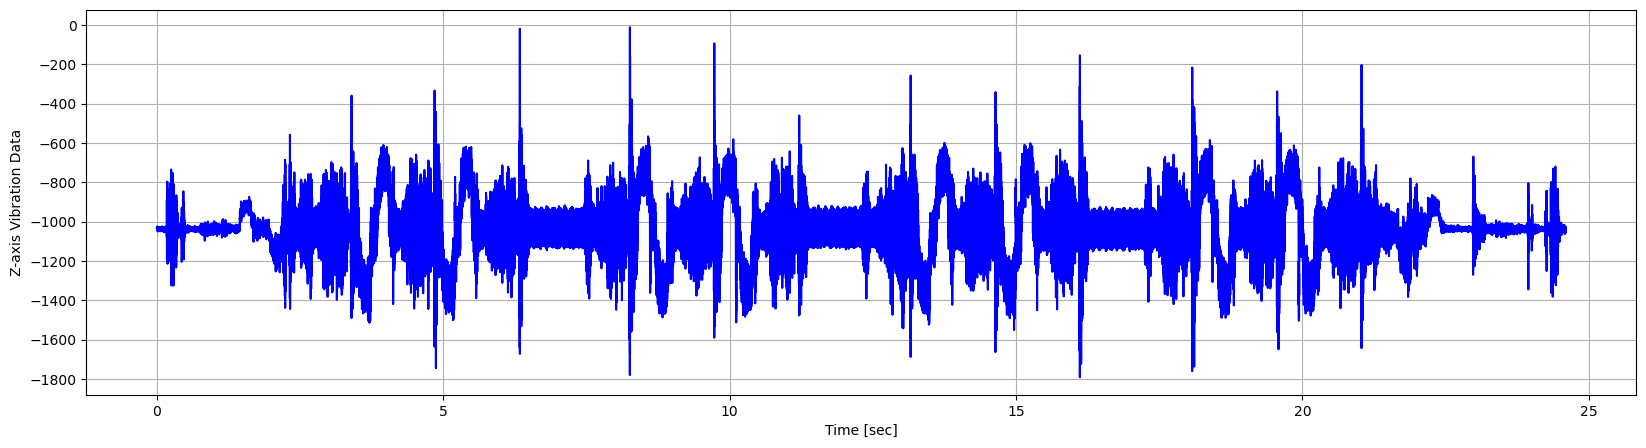

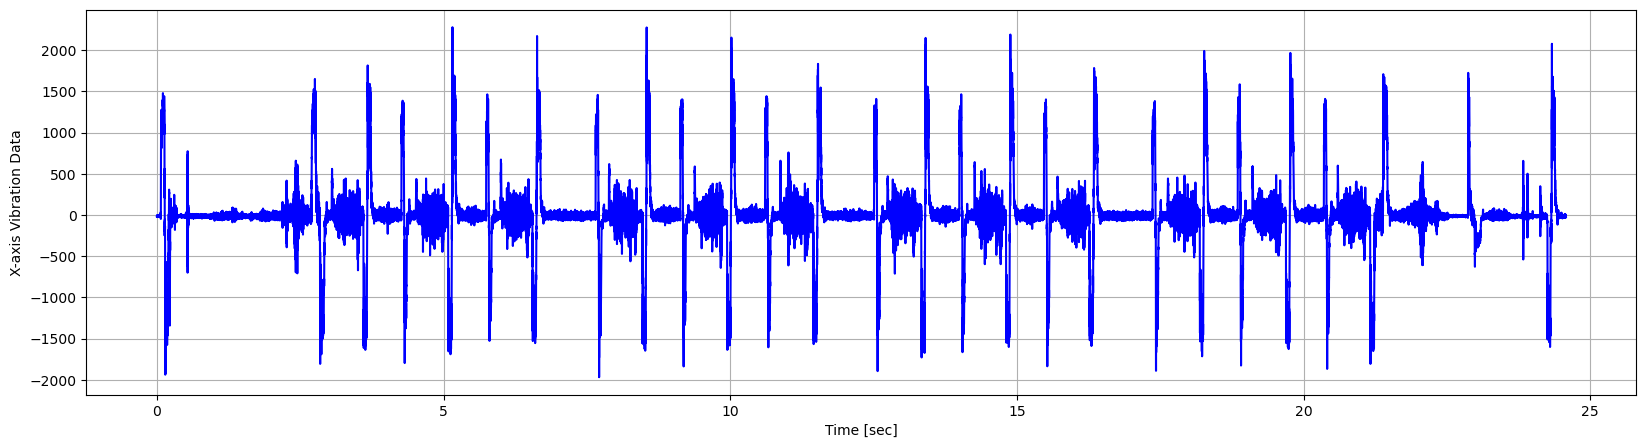

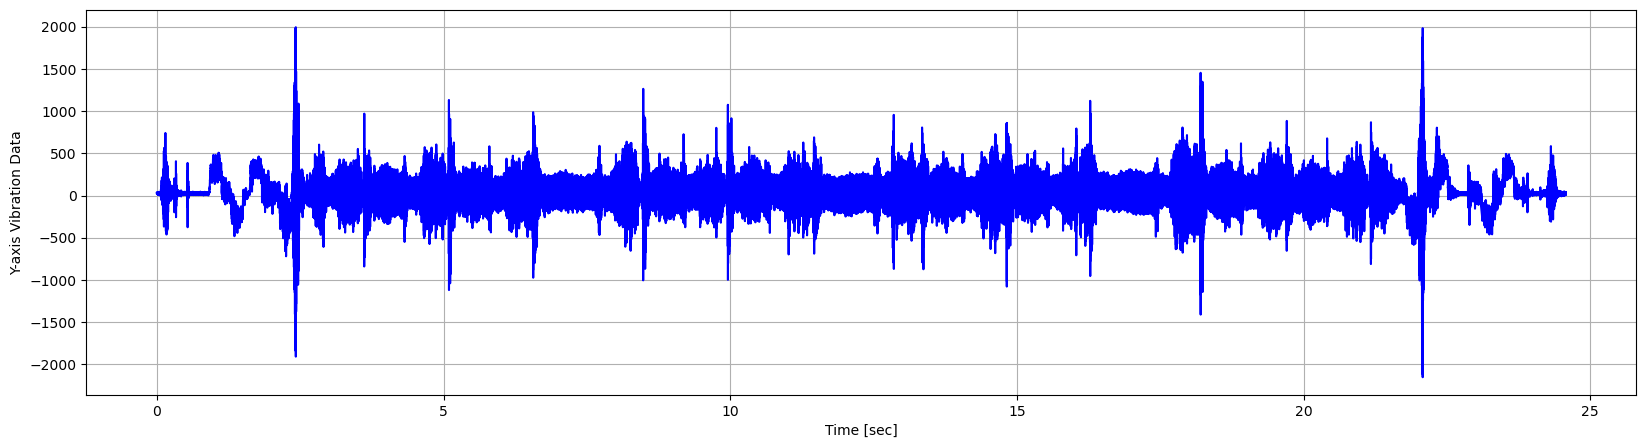

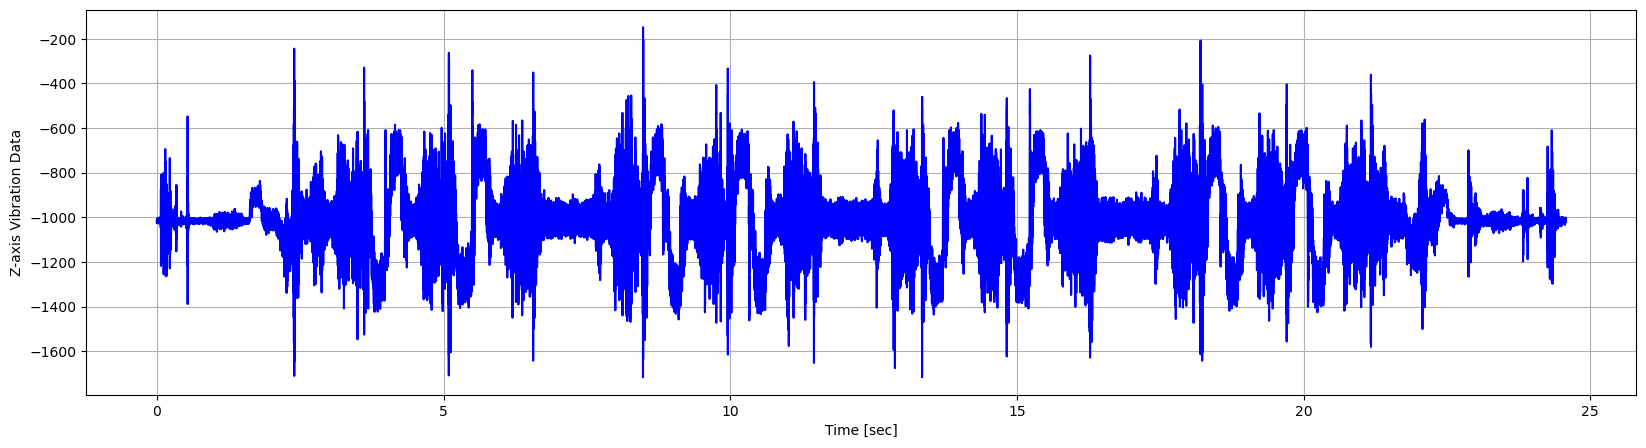

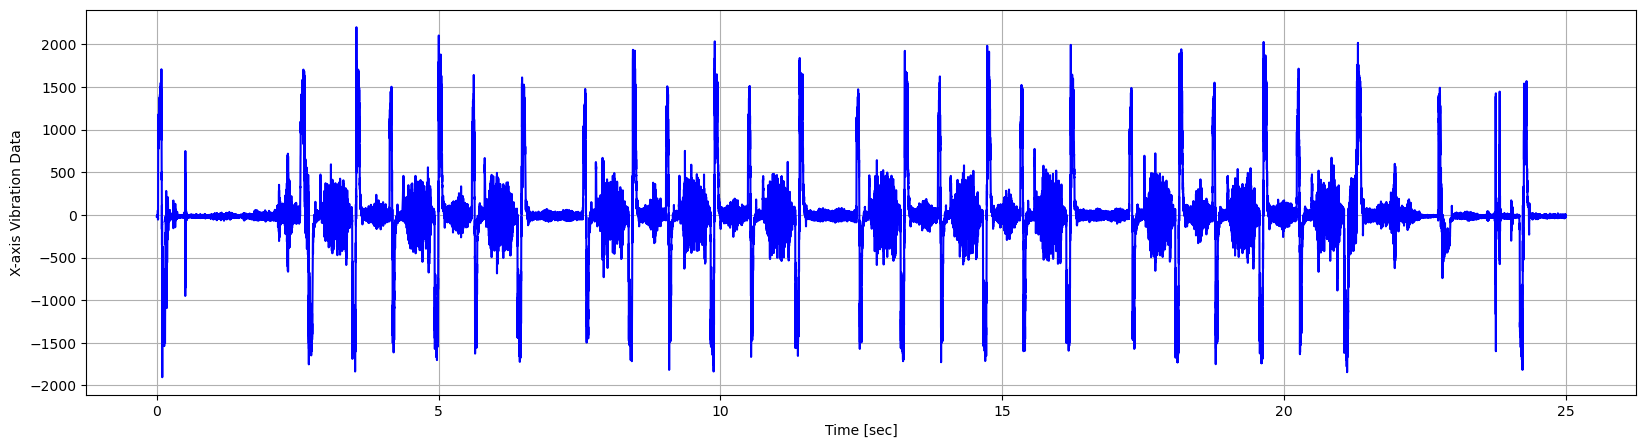

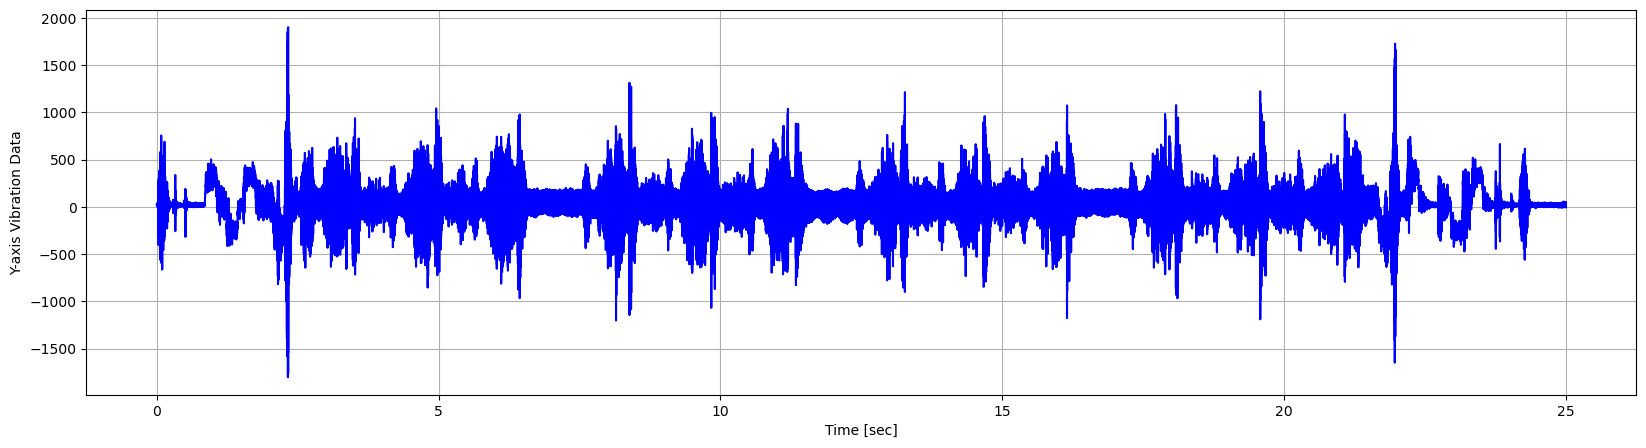

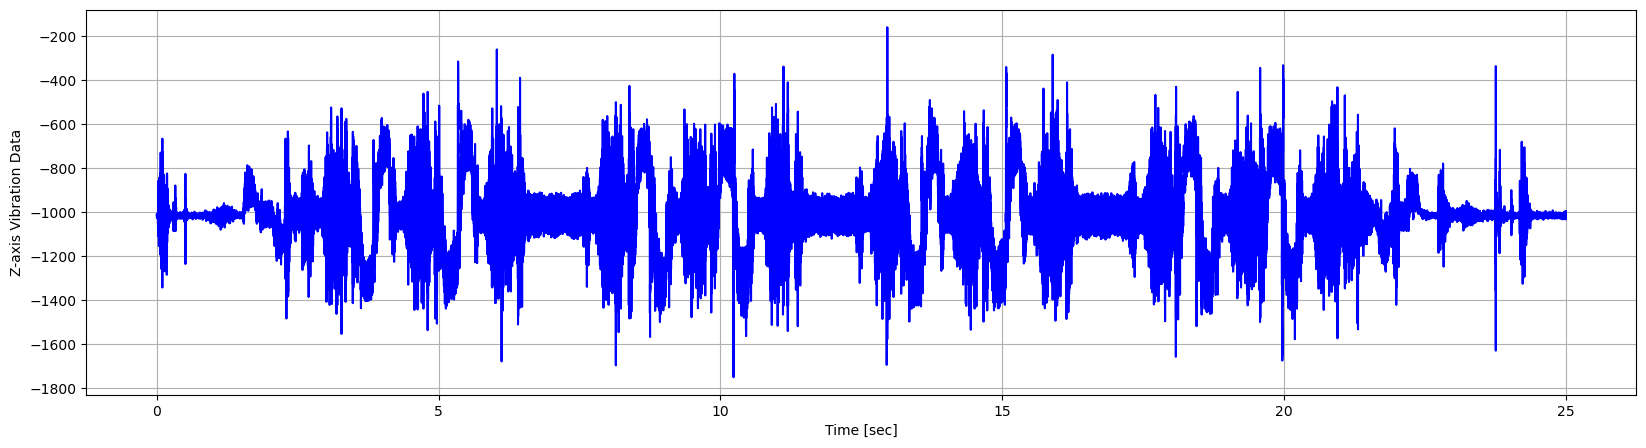

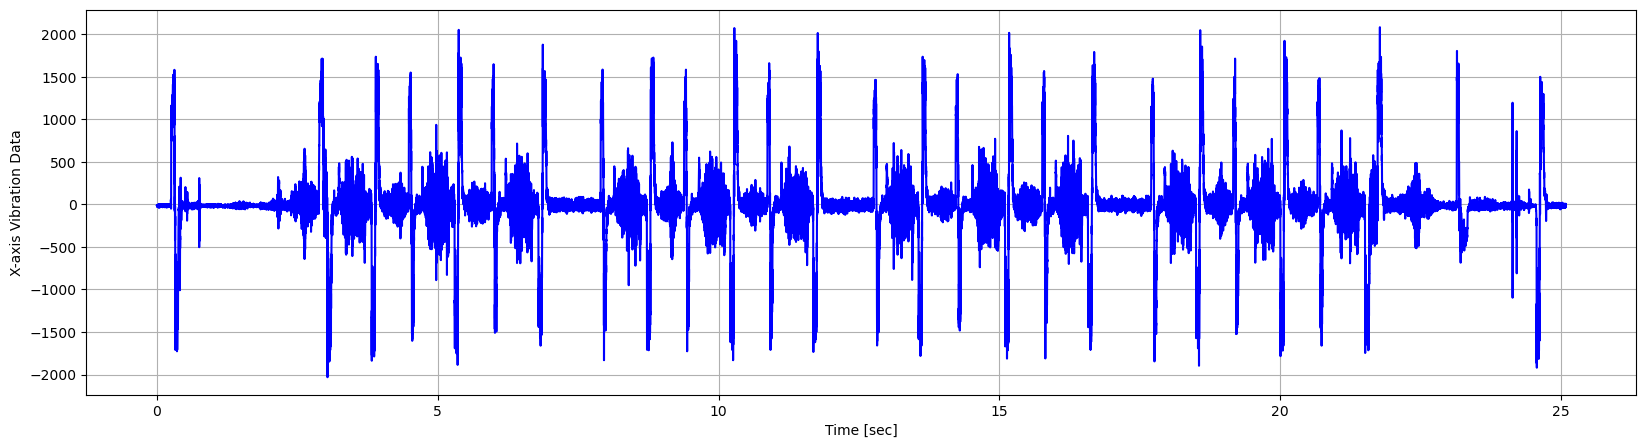

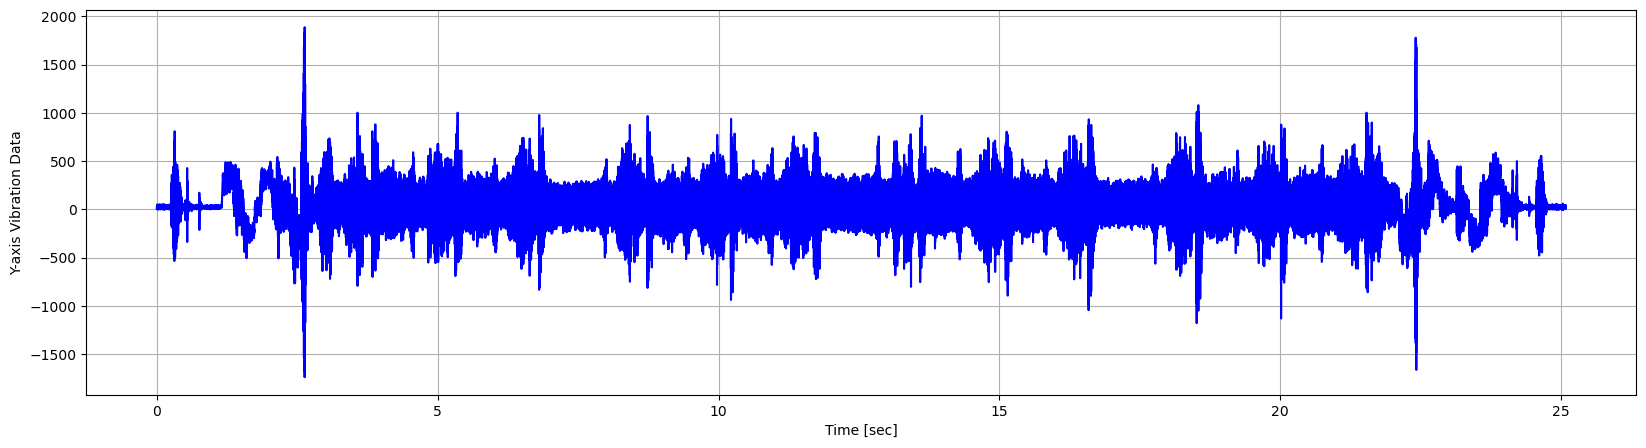

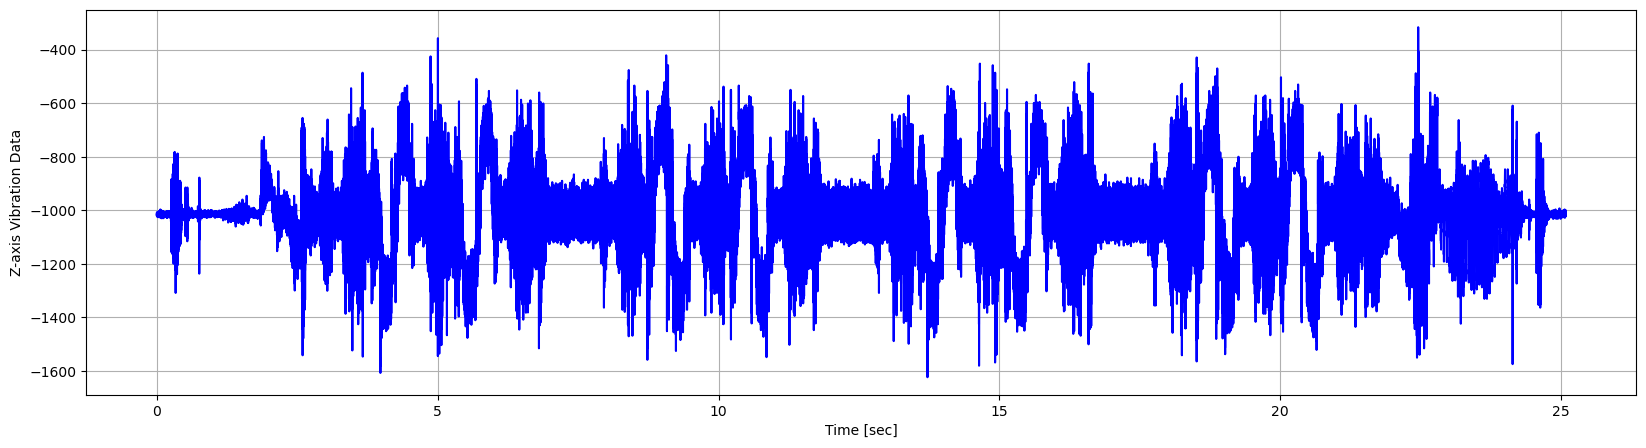

In [13]:
file1 = Path("./data/M01/OP07/good/M01_Feb_2019_OP07_000.h5").absolute()
file4 = Path("./data/M01/OP07/good/M01_Aug_2021_OP07_000.h5").absolute()
file2 = Path("./data/M01/OP07/good/M01_Aug_2019_OP07_000.h5").absolute()
file3 = Path("./data/M01/OP07/good/M01_Feb_2021_OP07_000.h5").absolute()

x = data_loader_utils.datafile_read(file1)
y = data_loader_utils.datafile_read(file2)
z = data_loader_utils.datafile_read(file3)
w = data_loader_utils.datafile_read(file4)

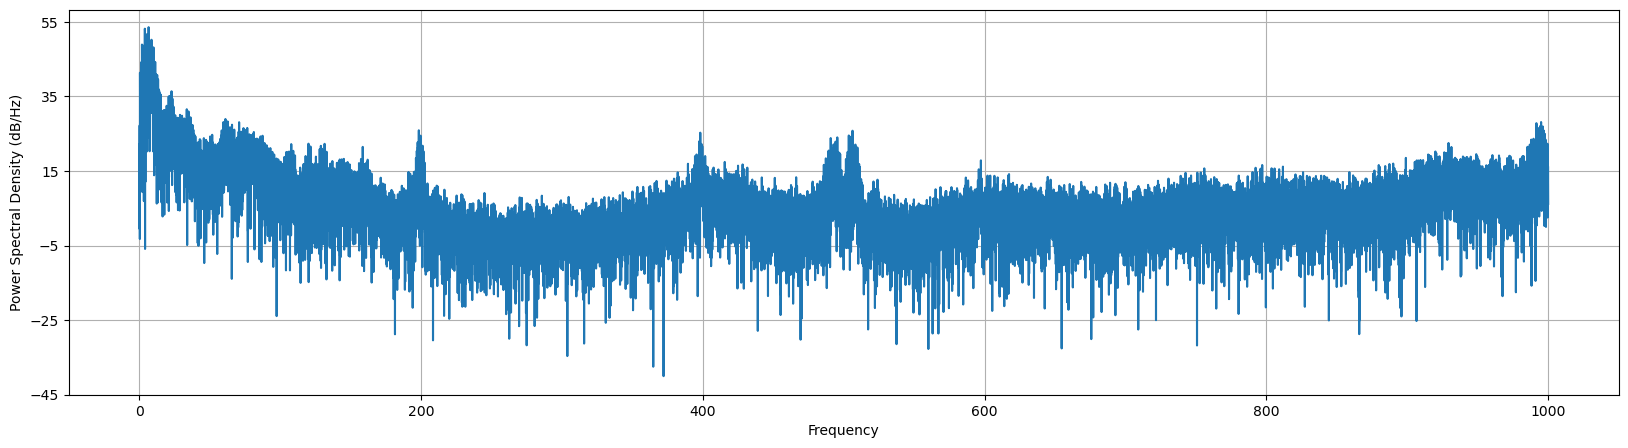

: max PSD = 2.5918e+01 at 198.50 Hz


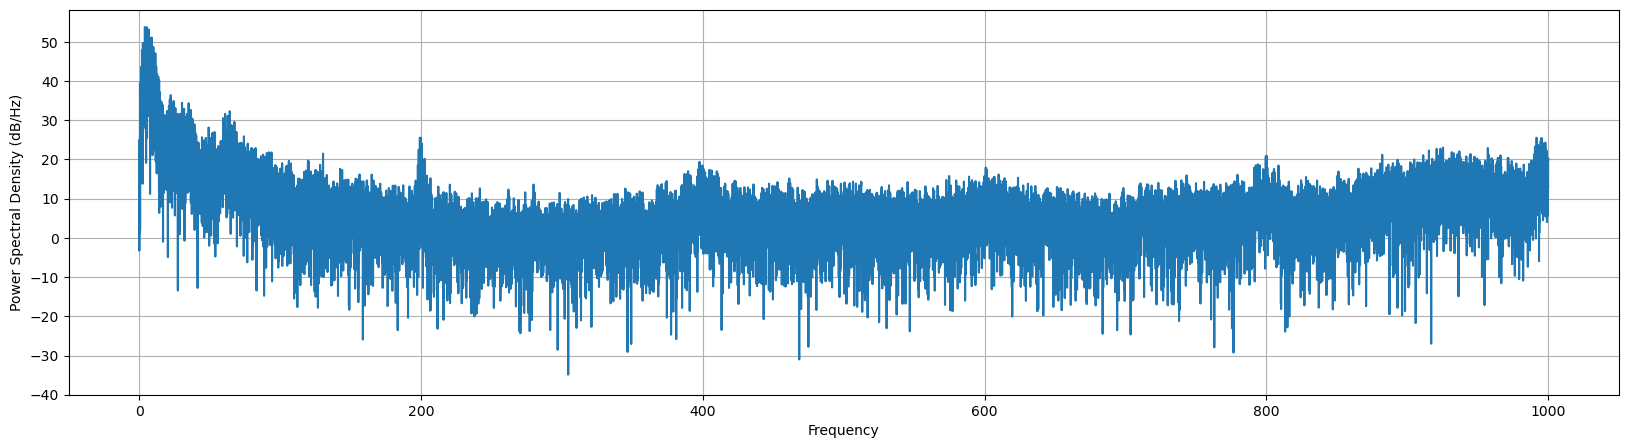

: max PSD = 2.5540e+01 at 199.26 Hz


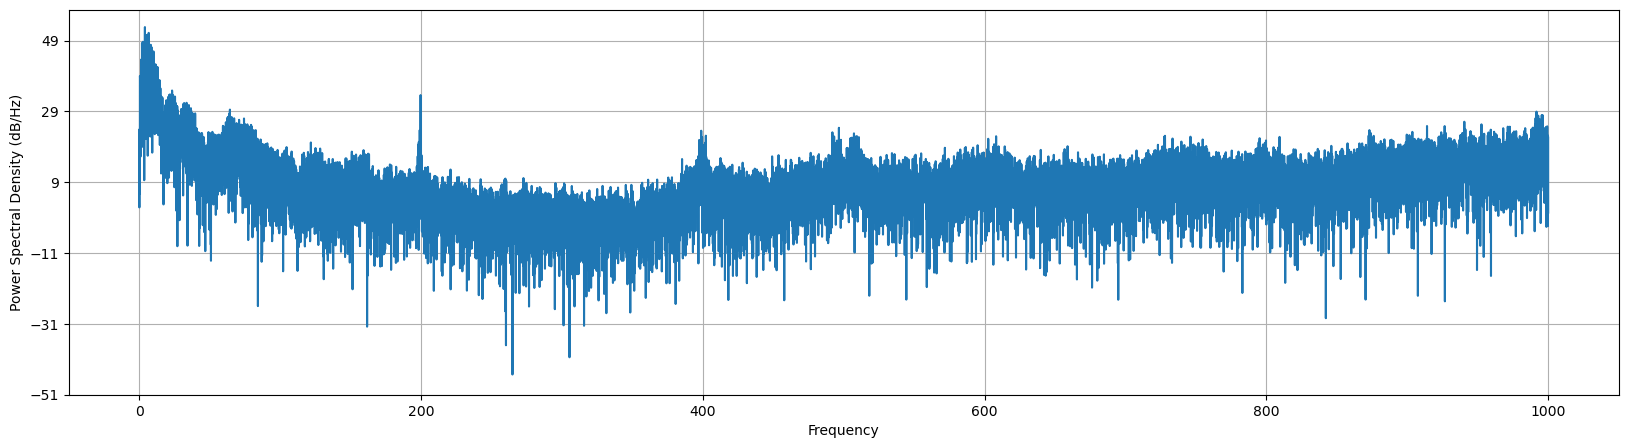

: max PSD = 3.3602e+01 at 199.76 Hz


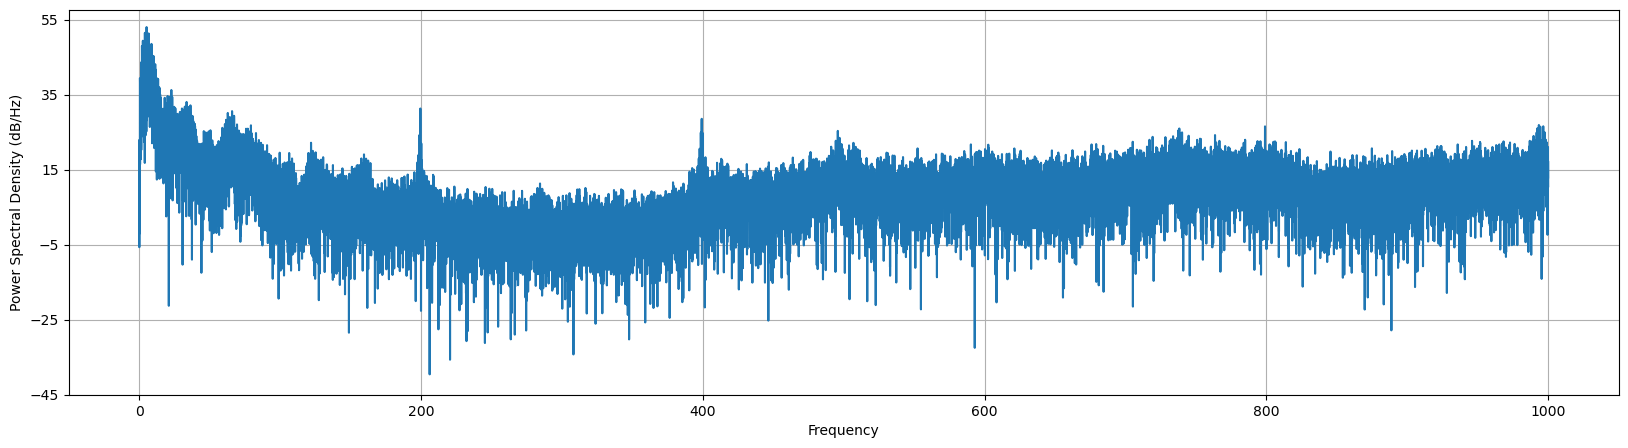

: max PSD = 3.1309e+01 at 199.62 Hz


In [15]:
Fs = 2000
dt = 1/Fs

def max_psd_in_band(signal, Fs, fmin=180, fmax=220):
    Pxx, freqs = plt.psd(signal, NFFT=len(signal), Fs=Fs)
    plt.close()  # prevent plotting

    band_mask = (freqs >= fmin) & (freqs <= fmax)
    return np.max(Pxx[band_mask]), freqs[band_mask][np.argmax(Pxx[band_mask])]


plt.figure(figsize=(20, 5))
plt.psd(x[:,0], NFFT = len(x), Fs = Fs)
plt.show()

max_val, freq_at_max = max_psd_in_band(x[:,0], Fs)
print(f": max PSD = {10*np.log10(max_val):.4e} at {freq_at_max:.2f} Hz")


plt.figure(figsize=(20, 5))
plt.psd(y[:,0], NFFT = len(y), Fs = Fs)
plt.show()

max_val, freq_at_max = max_psd_in_band(y[:,0], Fs)
print(f": max PSD = {10*np.log10(max_val):.4e} at {freq_at_max:.2f} Hz")

plt.figure(figsize=(20, 5))
plt.psd(z[:,0], NFFT = len(z), Fs = Fs)
plt.show()

max_val, freq_at_max = max_psd_in_band(z[:,0], Fs)
print(f": max PSD = {10*np.log10(max_val):.4e} at {freq_at_max:.2f} Hz")

plt.figure(figsize=(20, 5))
plt.psd(w[:,0], NFFT = len(w), Fs = Fs)
plt.show()

max_val, freq_at_max = max_psd_in_band(w[:,0], Fs)
print(f": max PSD = {10*np.log10(max_val):.4e} at {freq_at_max:.2f} Hz")

In [16]:
min_length = min(len(x),len(y))
numpy_correlation = np.corrcoef(x[0:min_length,0], y[0:min_length,0])[0, 1]
print('NumPy Correlation:', numpy_correlation)

NumPy Correlation: -0.034025995482521415


Original samples: 49200
New samples: 24600


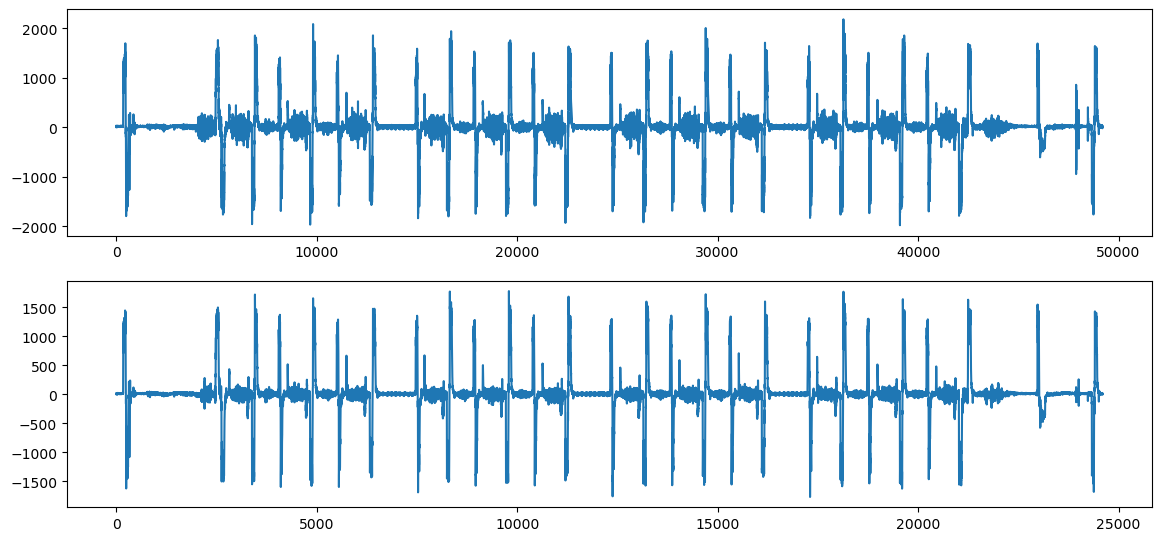

In [17]:
import numpy as np
from scipy import signal

def resample_milling_data(data, original_fs=2000, target_fs=1000):
    """
    Resamples the data from original_fs to target_fs.
    """
    # 1. Calculate the number of samples in the new signal
    # New Length = (Original Length * Target Frequency) / Original Frequency
    number_of_samples = int(len(data) * target_fs / original_fs)
    
    # 2. Resample the signal
    # scipy.signal.resample uses an FFT-based method which inherently 
    # handles anti-aliasing in the frequency domain.
    resampled_data = signal.resample(data, number_of_samples)
    
    return resampled_data

# --- Application and Tuning ---
# Load your signal (e.g., 132 seconds of OP00)
# original_data = load_data(...) 

# TUNE FREQUENCY HERE
ORIGINAL_FS = 2000  # Fixed based on the report 
TARGET_FS = 1000    # Change this to 500, 800, etc.

downsampled_signal = resample_milling_data(x[:,0], ORIGINAL_FS, TARGET_FS)

print(f"Original samples: {len(x[:,0])}")
print(f"New samples: {len(downsampled_signal)}")

plt.figure(figsize=(14, 10))
plt.subplot(3,1,1)
plt.plot(x[:,0])
plt.subplot(3,1,2)
plt.plot(downsampled_signal)

In [18]:
result = adfuller(downsampled_signal) 

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Interpretation
if result[1] < 0.05:
    print("Data is Stationary. You can use ARMA (d=0).")
else:
    print("Data is Non-Stationary. You must use ARIMA (d=1) or difference the data.")

ADF Statistic: -21.742668182281147
p-value: 0.0
Data is Stationary. You can use ARMA (d=0).


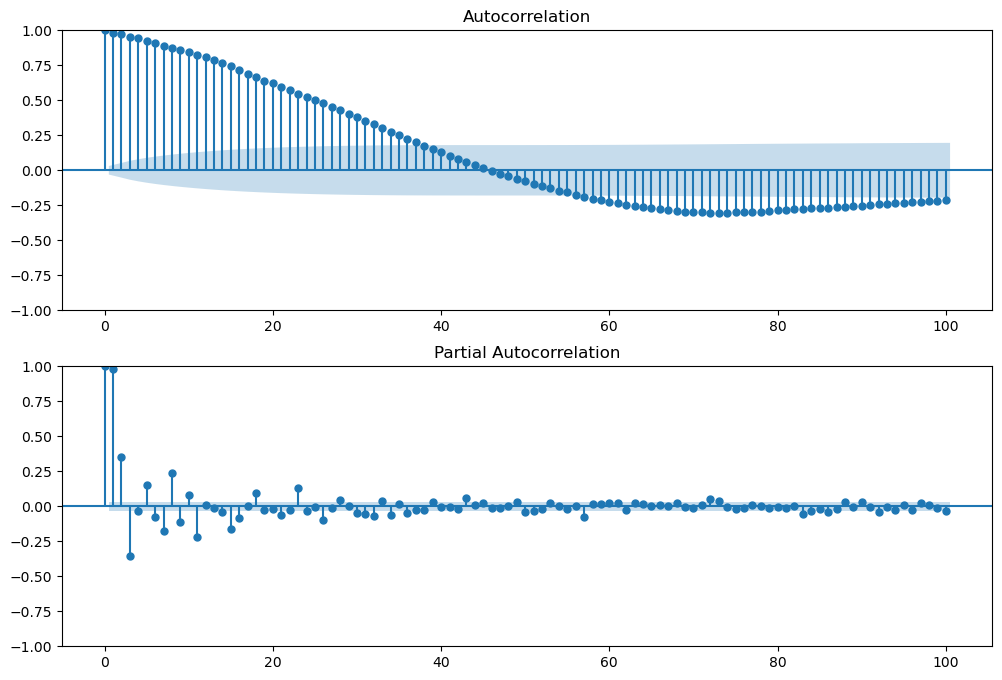

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF and PACF for the first 50 lags
plot_acf(downsampled_signal[2400:6500], lags=100, ax=ax1)
plot_pacf(downsampled_signal[2400:6500], lags=100, ax=ax2)
# x[0:5000, 0]
plt.show()

In [20]:
udf.calculate_arima_params_downsampled(downsampled_signal[2400:6500], 100)

Visual inspection suggests: p (AR) = 11, q (MA) = 37


--- Performance Metrics ---
Raw Signal Power: 28063.1250
Cleaned Signal Power: 20444.4040
Estimated SNR Improvement: 5.22 dB (Initial)


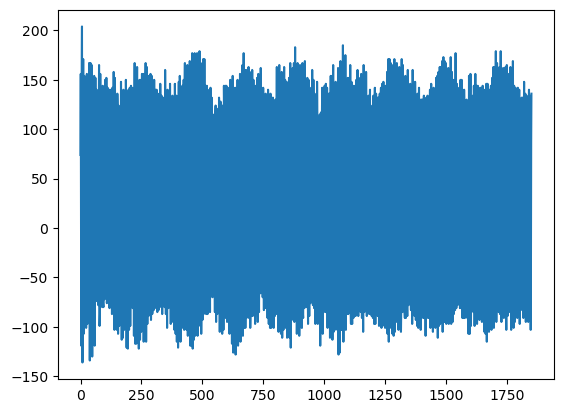

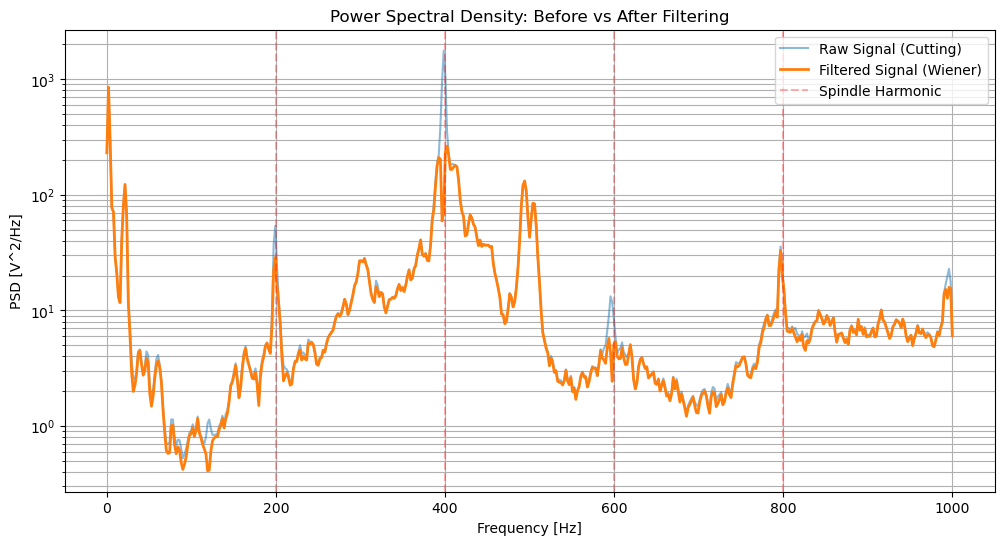

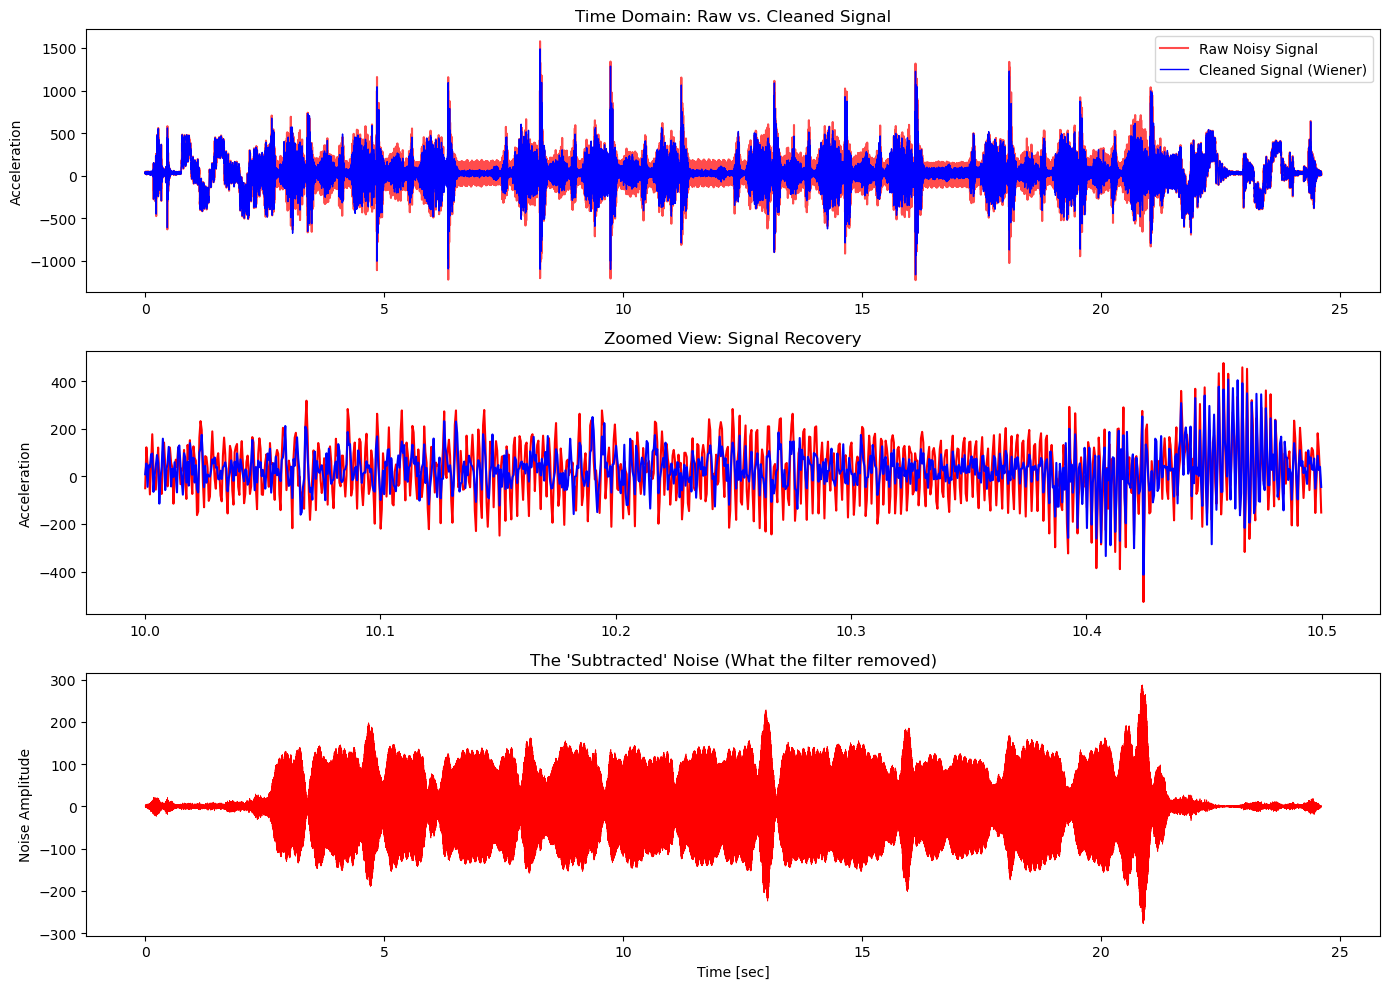

In [21]:
# Use wiener filter to remove noise (take as noise basis a section where 'air cutting' occurs)
noisy_signal = x[13000:14850,1]
plt.plot(noisy_signal)
clean_signal = udf.optimal_wiener_denoising_with_reference(x[:,1], noisy_signal)
udf.evaluate_denoising_performance(x[:,1], clean_signal, noisy_signal)
udf.plot_time_domain_denoising(x[:,1], clean_signal)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4100
Model:                 ARIMA(2, 0, 3)   Log Likelihood              -23746.807
Date:                Tue, 23 Dec 2025   AIC                          47507.615
Time:                        15:20:27   BIC                          47551.846
Sample:                             0   HQIC                         47523.274
                               - 4100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5868     85.701      0.019      0.985    -166.384     169.557
ar.L1          0.7050      0.038     18.455      0.000       0.630       0.780
ar.L2          0.2749      0.037      7.435      0.0

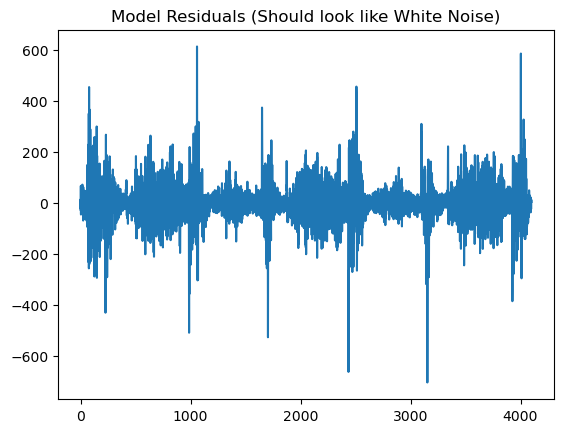

In [31]:
p, q = 2, 3 #Order of AR and MA
resampled_signal = downsampled_signal[2400:6500]
model_results = udf.fit_arma_44(resampled_signal,p,q)

# 4. Check if the model is 'Good' (Lecture 6 & 7 Analysis)
# Plot the residuals - they should look like White Noise
residuals = model_results.resid
plt.plot(residuals)
plt.title("Model Residuals (Should look like White Noise)")
plt.show()

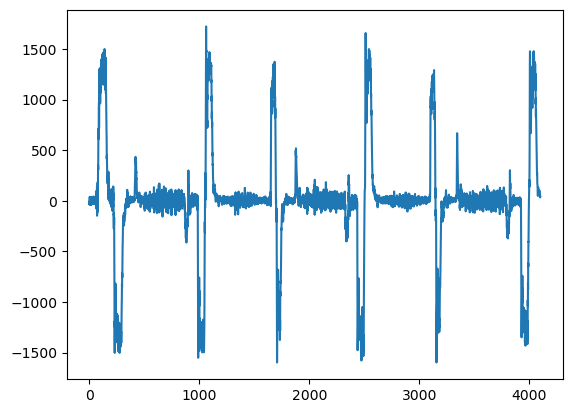

In [30]:
plt.plot(downsampled_signal[2400:6500])

[1. 1. 1. ... 1. 1. 1.]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4100
Model:               SARIMAX(2, 0, 3)   Log Likelihood              -23723.149
Date:                Tue, 23 Dec 2025   AIC                          47460.298
Time:                        15:20:52   BIC                          47504.522
Sample:                             0   HQIC                         47475.955
                               - 4100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7009     12.191      0.140      0.889     -22.192      25.594
ar.L1          0.7011      0.038     18.429      0.000       0.627       0.776
ar.L2          0.2790      0

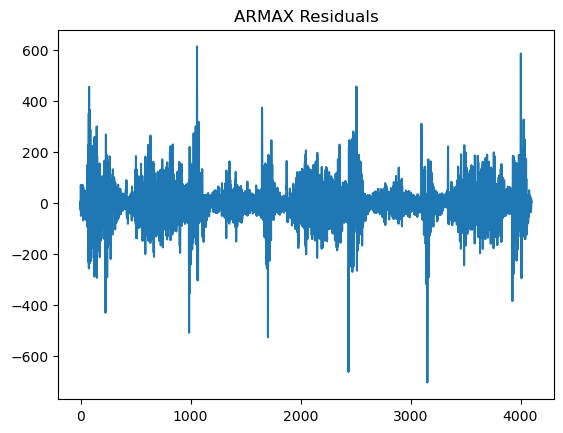

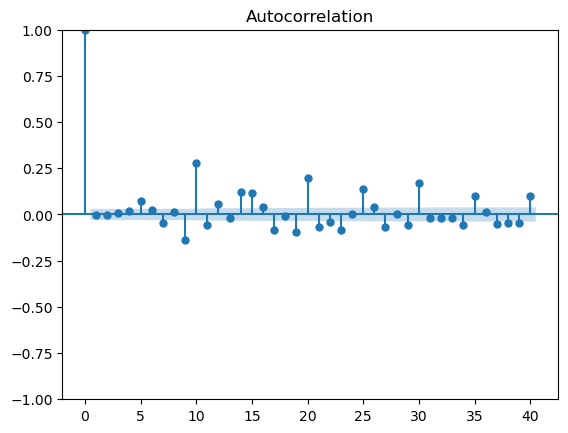

In [32]:
#Try with ARMAX model, but, as visible, no improvement

y = downsampled_signal[2400:6500]

threshold = 0.001 * np.std(y)
u = (np.abs(y) > threshold).astype(float)
print(u)
# Step 2: Fit ARMAX model
p, q = 2, 3
model = SARIMAX(
    y,
    exog=u,
    order=(p, 0, q),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

print(results.summary())

# Step 3: Analyze residuals
residuals = results.resid

plt.figure()
plt.plot(residuals)
plt.title("ARMAX Residuals")
plt.show()

plot_acf(residuals, lags=40)
plt.show()